there's a lot of non-bio relevant hits, so let's filter them out

In [63]:
import os
from pathlib import Path
root = Path('/Users/user/Coding/EV-D68-3C-protease/')
os.chdir(root)

In [89]:
from rdkit import Chem
import pymol2

neighbors = []
hits = []
for hit_group in ('hits.sdf', 'stolen_hits.sdf'):
    with Chem.SDMolSupplier(hit_group) as suppl:
        with pymol2.PyMOL() as pymol:
            pymol.cmd.load('reference.pdb', 'ref')
            pymol.cmd.fetch('2B0F')
            pymol.cmd.align('2B0F', 'ref')
            pymol.cmd.delete('ref')
            pymol.cmd.remove('%2B0F and not chain B')
            pymol.cmd.remove('solvent')
            for mol in suppl:
                hits.append(mol)
                pymol.cmd.read_molstr(Chem.MolToMolBlock(mol), 'mol')
                n_neighbors = pymol.cmd.count_atoms('%2B0F within 4 of mol')
                pymol.cmd.delete('mol')
                if n_neighbors > 0:
                    neighbors.append(mol)

 ExecutiveLoad-Detail: Detected mmCIF
 ExecutiveLoad-Detail: Detected mmCIF


In [90]:
len(neighbors), len(hits)

(44, 172)

In [91]:
# Save

with Chem.SDWriter('filtered_hits.sdf') as sdf:
    for mol in neighbors:
        if mol is None:
            continue
        # L for location, P for position, S for synthon
        name = mol.GetProp('_Name').replace('_', 'L').replace('§','P')
        mol.SetProp('_Name', name)
        sdf.write(mol)

In [93]:
from rdkit.Chem import Draw

with open('filtered_hits.png', 'wb') as fh:
    fh.write(Draw.MolsToGridImage(neighbors, legends=[n.GetProp('_Name') for n in neighbors]).data)

In [94]:
## FRAGMENT

from rdkit import Chem
from rdkit.Chem import BRICS, AllChem

fragments = []
for mol in neighbors:
    if mol is None:
        continue
    name = mol.GetProp('_Name')
    for atom in mol.GetAtoms():
        atom.SetProp('brics_ori_name', name)
        atom.SetIntProp('brics_ori_i', atom.GetIdx())
    for dummy in mol.GetAtomsMatchingQuery(AllChem.AtomNumEqualsQueryAtom(0)):
        # tritium
        dummy.SetAtomicNum(85)  # astatine just becase
        dummy.SetBoolProp('dummy_atom', True)
    i = 0
    for fragment in BRICS.BRICSDecompose(mol, keepNonLeafNodes=True, returnMols=True, minFragmentSize=4):
        dummies = list(fragment.GetAtomsMatchingQuery(AllChem.AtomNumEqualsQueryAtom(0)))
        if len(dummies) == 0:
            fragment.SetProp('_Name', name)
        else:
            i+=1
            fragment.SetProp('_Name', f'{name}S{i}')
        for dummy in dummies:
            dummy.SetAtomicNum(1)  # hydrogen!
            dummy.SetIsotope(0)
        for k, v in mol.GetPropsAsDict().items():
            if isinstance(v, str):
                fragment.SetProp(k, v)
            elif isinstance(v, int):
                fragment.SetIntProp(k, v)
            elif isinstance(v, float):
                fragment.SetDoubleProp(k, v)
            elif isinstance(v, bool):
                fragment.SetBoolProp(k, v)
            else:
                fragment.SetProp(k, str(v))
        for atom in fragment.GetAtomsMatchingQuery(AllChem.AtomNumEqualsQueryAtom(85)):
            atom.SetAtomicNum(0)
            atom.SetIsotope(0)
        fragments.append(AllChem.RemoveHs(fragment))

# Save

with Chem.SDWriter('fragmented_hits.sdf') as sdf:
    for mol in fragments:
        sdf.write(mol)

/Users/user/.conda/envs/py310/lib/python3.10/site-packages/rdkit/Chem/Draw/IPythonConsole.py:258: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


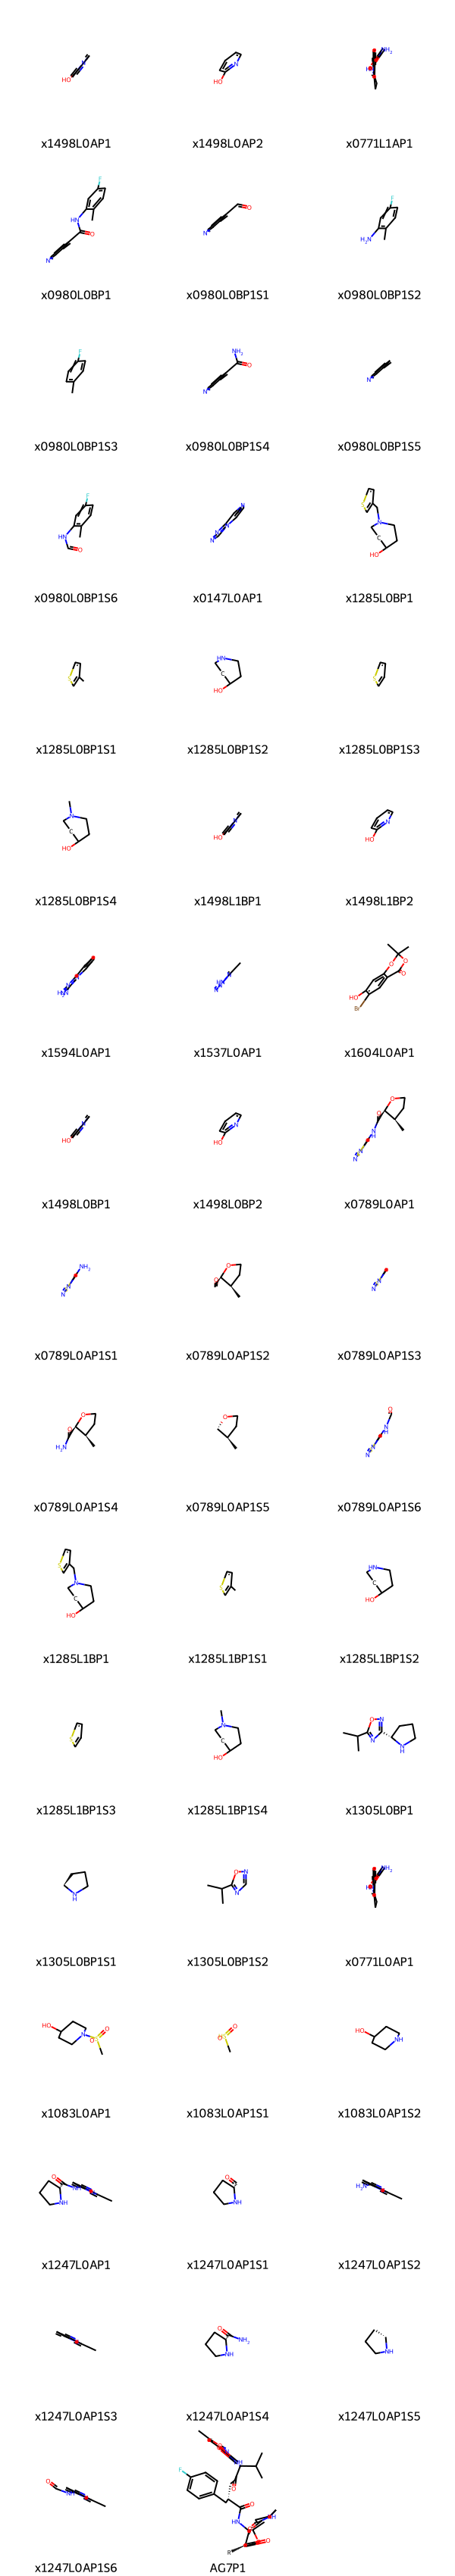

In [95]:
Draw.MolsToGridImage(fragments, legends=[n.GetProp('_Name') for n in fragments])

In [98]:
len(fragments)

992